###  https://pymoo.org/getting_started/part_2.html

In [596]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=2, # X 变量数量
                         n_obj=2, # f 问题数
                         n_ieq_constr=1,# g 约束条件数量
                         xl=np.array([-2,-2]), # X 自变量下限
                         xu=np.array([2,2])# X 自变量上限
                         ) 

    def _evaluate(self, x, out, *args, **kwargs):
        # 待求解函数 
        f1 = np.cos(x[0]+x[1]) #100 * (x[0]**2 + x[1]**2) 
        f2 = np.sin(x[0]-x[1]) #(x[0]-1)**2 + x[1]**2
        # f3 = (abs(x[0])<0.3)+(abs(x[1])<0.5)

        # 约束条件会选择 <= 0 的选择
        # g1 = 2*(x[0]-0.1) * (x[0]-0.9) / 0.18
        # g2 = - 20*(x[0]-0.4) * (x[0]-0.6) / 4.8
        # g3 = ((x[0]**2)<0.5)+((x[1]**2)>0.3)
        g3 = x[0]-0.7 #+(abs(x[1])<0.3)

        out["F"] = [f1, f2] #待求解问题
        #out["G"] = [g1, g2,g3] #约束条件
        out["G"] = [g3] #约束条件


problem = MyProblem()

* 您之所以意识到这个框架，可能是因为存在您喜欢使用的算法。 pymoo 遵循面向对象的方法，因此，我们接下来必须定义一个算法对象。根据优化问题的不同，不同的算法在不同类型的问题上会表现得更好或更差。建议首先了解算法背后的直觉，然后选择最适合解决您的优化问题的算法。 pymoo 中可用的算法列表可在此处找到。

* 在我们的例子中，优化问题相当简单，但应该考虑有两个目标和两个约束的方面。因此，让我们选择著名的多目标算法[NSGA-II](../algorithms/moo/nsga2.ipynb)。对于大多数算法，您可以选择默认的超参数，也可以通过修改它们来创建您自己的算法版本。例如，对于这个相对简单的问题，我们选择人口规模为 40 (`pop_size=40`)，并且每代中只有 10 (`n_offsprings=10`)。这种实现是一种贪婪的变体，可以提高更简单优化问题的收敛性，而不会出现优化方面的重大困难，例如局部帕累托前沿的存在。此外，我们启用重复检查（“eliminate_duplicates=True”），确保交配产生的后代在设计空间值方面与自身和现有种群不同。

In [597]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling,IntegerRandomSampling

algorithm = NSGA2(
    pop_size=90, # z种群数量
    n_offsprings=100, # 每代的数量
    sampling= FloatRandomSampling(), #抽样设置
     #交叉配对
    crossover=SBX(prob=0.9 #交叉配对概率
                  , eta=15),
    #变异
    mutation=PM(prob=0.8 #编译概率
                ,eta=20),
    eliminate_duplicates=True
)

* 此外，需要定义终止标准来启动优化过程。定义终止的最常见方法是限制函数求值的总数或简单地限制算法的迭代次数。此外，一些算法已经实现了自己的算法，例如单纯形退化时的 Nelder-Mead 或使用供应商库的 CMA-ES。由于这个问题的简单性，我们使用了相当少量的 40 次迭代算法。

In [598]:
from pymoo.termination import get_termination

termination = get_termination("n_gen", 90)
# termination = get_termination("nsga2")

* 最后，我们problem用我们定义的algorithm和来解决termination。函数式接口使用minimize方法。默认情况下，minimize执行算法和终止对象的深层复制，以保证它们在函数调用期间不会被修改。这对于确保使用相同随机种子的重复函数调用最终得到相同的结果非常重要。当算法终止时，该minimize函数返回一个Result对象。

In [599]:
from pymoo.optimize import minimize

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

X = res.X
F = res.F

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       90 |      7 |  0.000000E+00 |  0.1912845192 |             - |             -
     2 |      190 |      5 |  0.000000E+00 |  0.000000E+00 |  0.0119558463 |         ideal
     3 |      290 |      8 |  0.000000E+00 |  0.000000E+00 |  0.0412643720 |             f
     4 |      390 |     14 |  0.000000E+00 |  0.000000E+00 |  0.6132318573 |         nadir
     5 |      490 |     19 |  0.000000E+00 |  0.000000E+00 |  0.7796115248 |         nadir
     6 |      590 |     21 |  0.000000E+00 |  0.000000E+00 |  0.0014395791 |             f
     7 |      690 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0062988488 |             f
     8 |      790 |     35 |  0.000000E+00 |  0.000000E+00 |  0.0029146602 |             f
     9 |      890 |     32 |  0.000000E+00 |  0.000000E+00 |  5.4678928181 |         nadir
    10 |      990 |     41 |  0.000000E+00 |  0.000000E+00 |  0.2715904563 |         nadir

In [600]:
X

array([[-1.9892955 , -1.15229969],
       [-1.93118763, -0.3603872 ],
       [-2.        , -0.42941113],
       [-1.9321642 , -0.36149768],
       [-1.99998524, -0.68401365],
       [-1.99999769, -0.70328614],
       [-2.        , -0.91270829],
       [-1.99999999, -0.97219159],
       [-2.        , -0.72069179],
       [-1.99969111, -1.1419944 ],
       [-1.98932828, -1.15229969],
       [-1.99999981, -0.44998962],
       [-2.        , -1.04954022],
       [-1.99999999, -0.90119233],
       [-2.        , -1.06707356],
       [-1.99999973, -0.98784605],
       [-2.        , -0.61526221],
       [-1.99999979, -0.67016928],
       [-1.99999868, -0.9245961 ],
       [-2.        , -0.65137489],
       [-1.99999995, -0.60017981],
       [-1.9999997 , -0.62957026],
       [-2.        , -0.73529463],
       [-1.99999978, -0.55993718],
       [-1.99999982, -0.71066274],
       [-1.99999997, -0.43360606],
       [-2.        , -0.6428753 ],
       [-1.99999996, -0.57144752],
       [-2.        ,

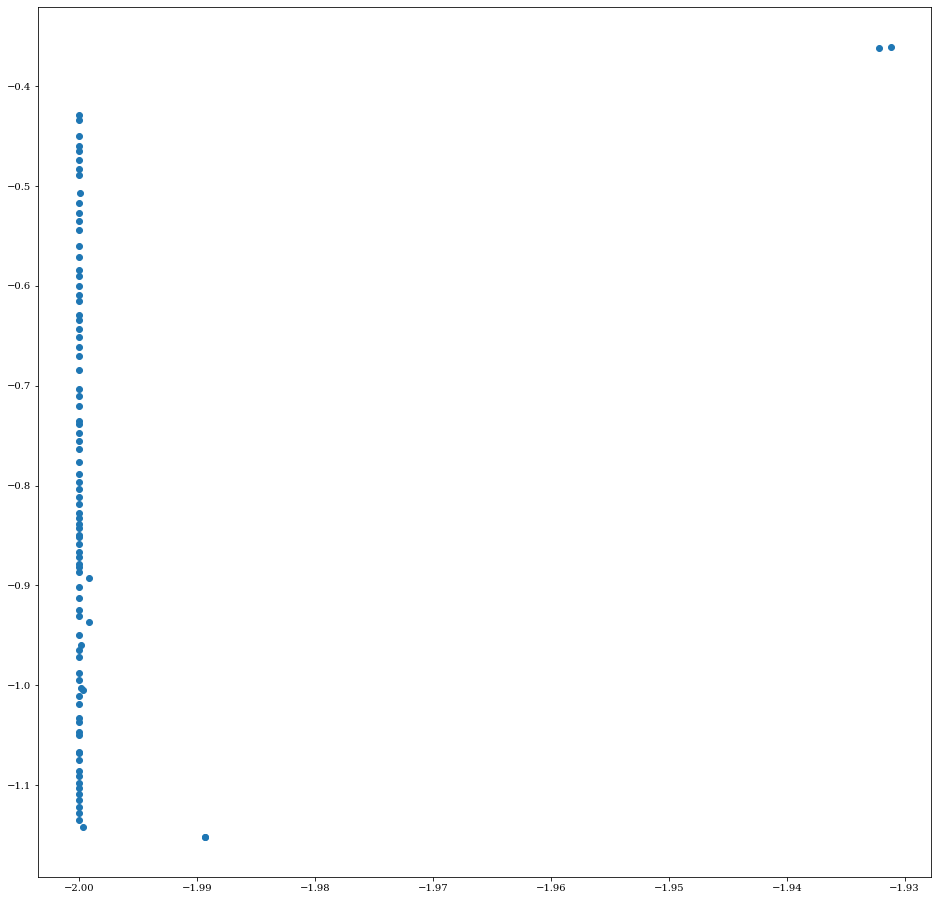

In [606]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(16,16))
plt.scatter(X[:,0],X[:,-1])

In [602]:
F.shape

(90, 2)

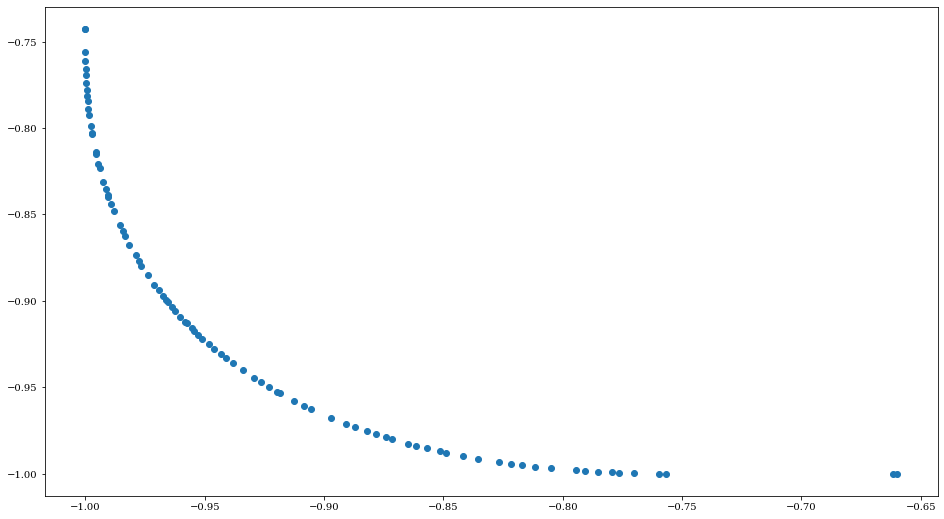

In [608]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(16,9))
plt.scatter(F[:,0],F[:,-1])

In [604]:
import numpy as np
from pymoo.factory import get_algorithm,get_problem
from pymoo.optimize import minimize

#
class MyProblem:
    def __init__(self):
        self.n_var = 2
        

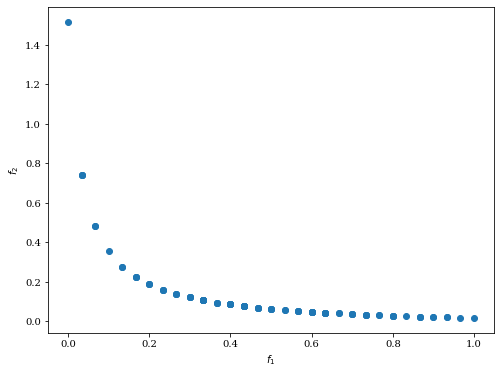

In [605]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.problems import get_problem
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

problem = get_problem("zdt5")

algorithm = NSGA2(pop_size=100,
                  sampling=BinaryRandomSampling(),
                  crossover=TwoPointCrossover(),
                  mutation=BitflipMutation(),
                  eliminate_duplicates=True)

res = minimize(problem,
               algorithm,
               ('n_gen', 500),
               seed=1,
               verbose=False)

Scatter().add(res.F).show()